In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(ggplot2))
suppressMessages(library(saqgetr))


suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

# Data variables

In [2]:
municipio = "Santander"
site = ""

data.by.file = FALSE

pollutant = c("no2")
start_dt = 2015

# Lockdown dates

In [3]:
# Prelockdown
start.pre.lckdwn <- ymd_hms("2020-01-01 00:00:00")
end.pre.lckdwn <- ymd_hms("2020-03-14 00:00:00")

# lockdown
start.lckdwn <- ymd_hms("2020-03-14 00:00:00")
end.lckdwn <- ymd_hms("2020-04-28 00:00:00")

# poslockdown
start.pos.lckdwn <- ymd_hms("2020-05-01 00:00:00")
end.pos.lckdwn <- ymd_hms("2020-06-21 00:00:00")

# 2 lockdown
start.2.lckdwn <- ymd_hms("2020-10-25 00:00:00")

---

In [4]:
date.as.datetime <- function(dataFrame){
    # Mutate date column from dataFrame into datatime format using
    # lubridate package assuming that date format yyyy-mm-dd hh:mm:ss
    
    dataFrame$date <- ymd_hms(dataFrame$date)
    dataFrame
}


group.dy <- function(dataFrame, unit="day", FUN="mean") {
    # Group data by unit using FUN function
    
    dataFrame$date <- floor_date(dataFrame$date, unit=unit)
    new.df <- aggregate(dataFrame$value, 
                        by=list(dataFrame$date, dataFrame$variable, dataFrame$site), 
                        FUN, na.rm=TRUE, na.action=na.omit)
    names(new.df) <- c("date", "variable", "site", "value")
    new.df
}

In [5]:
if (site == "" && municipio != "") {

    stations <- read.csv("../data/csv/sitesAQ.csv",
                         stringsAsFactors=FALSE) %>%
                filter(Municipio == municipio)
    site <- levels(as.factor(stations$site))
}
site

[1] "es1580a"

In [6]:
if (data.by.file) {
    data.AQ <- read.csv(paste("../data/csv/dataAQ/",
                                 site,
                                 ".csv", sep="")) %>%
                    filter(variable %in% pollutant) %>%
                    date.as.datetime() %>%
                    filter(date >= start_dt)
} else {
    suppressMessages(data.AQ <- get_saq_observations(
        site = site,
        variable = pollutant,
        start = 2015,
        end = 2020,
        valid_only = TRUE,
        verbose = TRUE
    ))
}
head(data.AQ)

date,date_end,site,variable,process,summary,validity,unit,value
<dttm>,<dttm>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
2015-01-01 00:00:00,2015-01-01 01:00:00,es1580a,no2,118046,1,1,ug.m-3,42.75
2015-01-01 01:00:00,2015-01-01 02:00:00,es1580a,no2,118046,1,1,ug.m-3,37.75
2015-01-01 02:00:00,2015-01-01 03:00:00,es1580a,no2,118046,1,1,ug.m-3,39.00
2015-01-01 03:00:00,2015-01-01 04:00:00,es1580a,no2,118046,1,1,ug.m-3,29.50
2015-01-01 04:00:00,2015-01-01 05:00:00,es1580a,no2,118046,1,1,ug.m-3,34.50
2015-01-01 05:00:00,2015-01-01 06:00:00,es1580a,no2,118046,1,1,ug.m-3,37.75


# `saqgetr` Media diaria

Para el caso de SANTANDER CENTRO no te devuelve ningun dato con resolucion diaria, y para el caso de Madrid ESCUELAS AGUIRRE de algunos contaminantes si te devuelve la resolucion diaria, pero en concreto para el NO2. Suponemos que `saq_clean_observations()` maneja los `NA` de alguna manera especial de tal forma que cuando hasy demasiados como para no poder hacer la media no te devuelve nada.

(No usaran `na.rm`??????)

```R
data.AQ.cln <- saq_clean_observations(data.AQ,
                                      summary = "day",
                                      valid_only = TRUE,
                                      #spread = TRUE
                                     )
head(data.AQ.cln)
```

# Propio Calculo de  Media diaria

In [7]:
data.AQ.dy <- data.AQ %>%
                group.dy(unit="day", FUN="mean")

# Comparar Datos por Año

In [8]:
data.20 <- data.AQ.dy[year(data.AQ.dy$date) == "2020",]
data.19 <- data.AQ.dy[year(data.AQ.dy$date) == "2019",]
year(data.19$date) <- 2020

data.15.19 <- data.AQ.dy[year(data.AQ.dy$date) < "2020",]
year(data.15.19$date) <- 2020
data.15.19 <- aggregate(data.15.19$value, 
                        by=list(data.15.19$date, data.15.19$variable, data.15.19$site), 
                        mean, na.rm=TRUE, na.action=na.omit)
names(data.15.19) <- c("date", "variable", "site", "value")

head(data.19)

,date,variable,site,value
,<dttm>,<chr>,<chr>,<dbl>
1427,2020-01-01,no2,es1580a,24.77778
1428,2020-01-04,no2,es1580a,29.26042
1429,2020-01-05,no2,es1580a,34.70833
1430,2020-01-06,no2,es1580a,30.78125
1431,2020-01-07,no2,es1580a,25.67708
1432,2020-01-08,no2,es1580a,31.83333


In [9]:
data.all <- merge(x=data.20, y=data.19, by=c("date", "variable", "site"), all=F) %>%
                rename(value.20 = value.x,
                       value.19 = value.y)
data.all <- merge(x=data.all, y=data.15.19, by=c("date", "variable", "site"), all=F) %>%
                rename(value.15.19 = value)

head(data.all, 10)

,date,variable,site,value.20,value.19,value.15.19
,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,2020-01-01,no2,es1580a,36.37500,24.77778,40.64722
2,2020-01-04,no2,es1580a,44.12500,29.26042,49.71250
3,2020-01-05,no2,es1580a,28.91667,34.70833,43.74167
4,2020-01-06,no2,es1580a,34.79167,30.78125,40.20833
5,2020-01-07,no2,es1580a,42.04545,25.67708,48.07500
6,2020-01-08,no2,es1580a,54.95833,31.83333,52.99167
7,2020-01-09,no2,es1580a,41.66667,37.76042,47.18542
8,2020-01-10,no2,es1580a,40.66667,33.85417,40.76784
9,2020-01-11,no2,es1580a,49.16667,43.53750,36.02000


# Obtener la variacion por anhos

In [10]:
data.all$variacion.19 <- (data.all$value.20 - data.all$value.19) / data.all$value.19
data.all$variacion.15.19 <- (data.all$value.20 - data.all$value.15.19) / data.all$value.15.19
head(data.all)

,date,variable,site,value.20,value.19,value.15.19,variacion.19,variacion.15.19
,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-01-01,no2,es1580a,36.37500,24.77778,40.64722,0.4680493,-0.10510490
2,2020-01-04,no2,es1580a,44.12500,29.26042,49.71250,0.5080100,-0.11239628
3,2020-01-05,no2,es1580a,28.91667,34.70833,43.74167,-0.1668667,-0.33892170
4,2020-01-06,no2,es1580a,34.79167,30.78125,40.20833,0.1302876,-0.13471503
5,2020-01-07,no2,es1580a,42.04545,25.67708,48.07500,0.6374700,-0.12541956
6,2020-01-08,no2,es1580a,54.95833,31.83333,52.99167,0.7264398,0.03711275


In [11]:
poll <- "no2"
variaciones <- data.frame(matrix(data=rep(NA, 20), nrow=2, ncol=10))
names(variaciones) <- c("pre.lockdown", "pre.lockdown.std", 
                        "lockdown", "lockdown.std", 
                        "pos.lockdown", "pos.lockdown.std",
                        "normalidad", "normalidad.std",
                        "2.lockdown", "2.lockdown.std")

row.names(variaciones) <- c("2019", "2015-2019")

data.poll <- data.all[data.all$variable == poll, ]

variaciones[, 1] <- c(mean(data.poll[data.poll$date < start.lckdwn, "variacion.19"], na.rm=TRUE),
                      mean(data.poll[data.poll$date < start.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 2] <- c(sd(data.poll[data.poll$date < start.lckdwn, "variacion.19"], na.rm=TRUE),
                      sd(data.poll[data.poll$date < start.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 3] <- c(mean(data.poll[data.poll$date > start.lckdwn &
                                     data.poll$date < end.lckdwn, "variacion.19"], na.rm=TRUE),
                      mean(data.poll[data.poll$date > start.lckdwn &
                                     data.poll$date < end.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 4] <- c(sd(data.poll[data.poll$date > start.lckdwn &
                                     data.poll$date < end.lckdwn, "variacion.19"], na.rm=TRUE),
                      sd(data.poll[data.poll$date > start.lckdwn &
                                     data.poll$date < end.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 5] <- c(mean(data.poll[data.poll$date > start.pos.lckdwn &
                                     data.poll$date < end.pos.lckdwn, "variacion.19"], na.rm=TRUE),
                      mean(data.poll[data.poll$date > start.pos.lckdwn &
                                     data.poll$date < end.pos.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 6] <- c(sd(data.poll[data.poll$date > start.pos.lckdwn &
                                     data.poll$date < end.pos.lckdwn, "variacion.19"], na.rm=TRUE),
                      sd(data.poll[data.poll$date > start.pos.lckdwn &
                                     data.poll$date < end.pos.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 7] <- c(mean(data.poll[data.poll$date > end.pos.lckdwn &
                                     data.poll$date < start.2.lckdwn, "variacion.19"], na.rm=TRUE),
                      mean(data.poll[data.poll$date > end.pos.lckdwn &
                                     data.poll$date < start.2.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 8] <- c(sd(data.poll[data.poll$date > end.pos.lckdwn &
                                     data.poll$date < start.2.lckdwn, "variacion.19"], na.rm=TRUE),
                      sd(data.poll[data.poll$date > end.pos.lckdwn &
                                     data.poll$date < start.2.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 9] <- c(mean(data.poll[data.poll$date > start.2.lckdwn, "variacion.19"], na.rm=TRUE),
                      mean(data.poll[data.poll$date > start.2.lckdwn, "variacion.15.19"], na.rm=TRUE))
variaciones[, 10] <- c(sd(data.poll[data.poll$date > start.2.lckdwn, "variacion.19"], na.rm=TRUE),
                      sd(data.poll[data.poll$date > start.2.lckdwn, "variacion.15.19"], na.rm=TRUE))

head(variaciones)

,pre.lockdown,pre.lockdown.std,lockdown,lockdown.std,pos.lockdown,pos.lockdown.std,normalidad,normalidad.std,2.lockdown,2.lockdown.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,0.337452686,0.5915855,-0.3569009,0.4398414,-0.07240364,0.5667908,-0.3706604,0.3662372,-0.5898076,0.2225370
2015-2019,-0.002490119,0.3287928,-0.4733396,0.2937451,-0.38294186,0.2368711,-0.4782407,0.2000270,-0.6535030,0.1720202


In [12]:
variaciones*100

,pre.lockdown,pre.lockdown.std,lockdown,lockdown.std,pos.lockdown,pos.lockdown.std,normalidad,normalidad.std,2.lockdown,2.lockdown.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,33.7452686,59.15855,-35.69009,43.98414,-7.240364,56.67908,-37.06604,36.62372,-58.98076,22.25370
2015-2019,-0.2490119,32.87928,-47.33396,29.37451,-38.294186,23.68711,-47.82407,20.00270,-65.35030,17.20202


# Representar Resultados

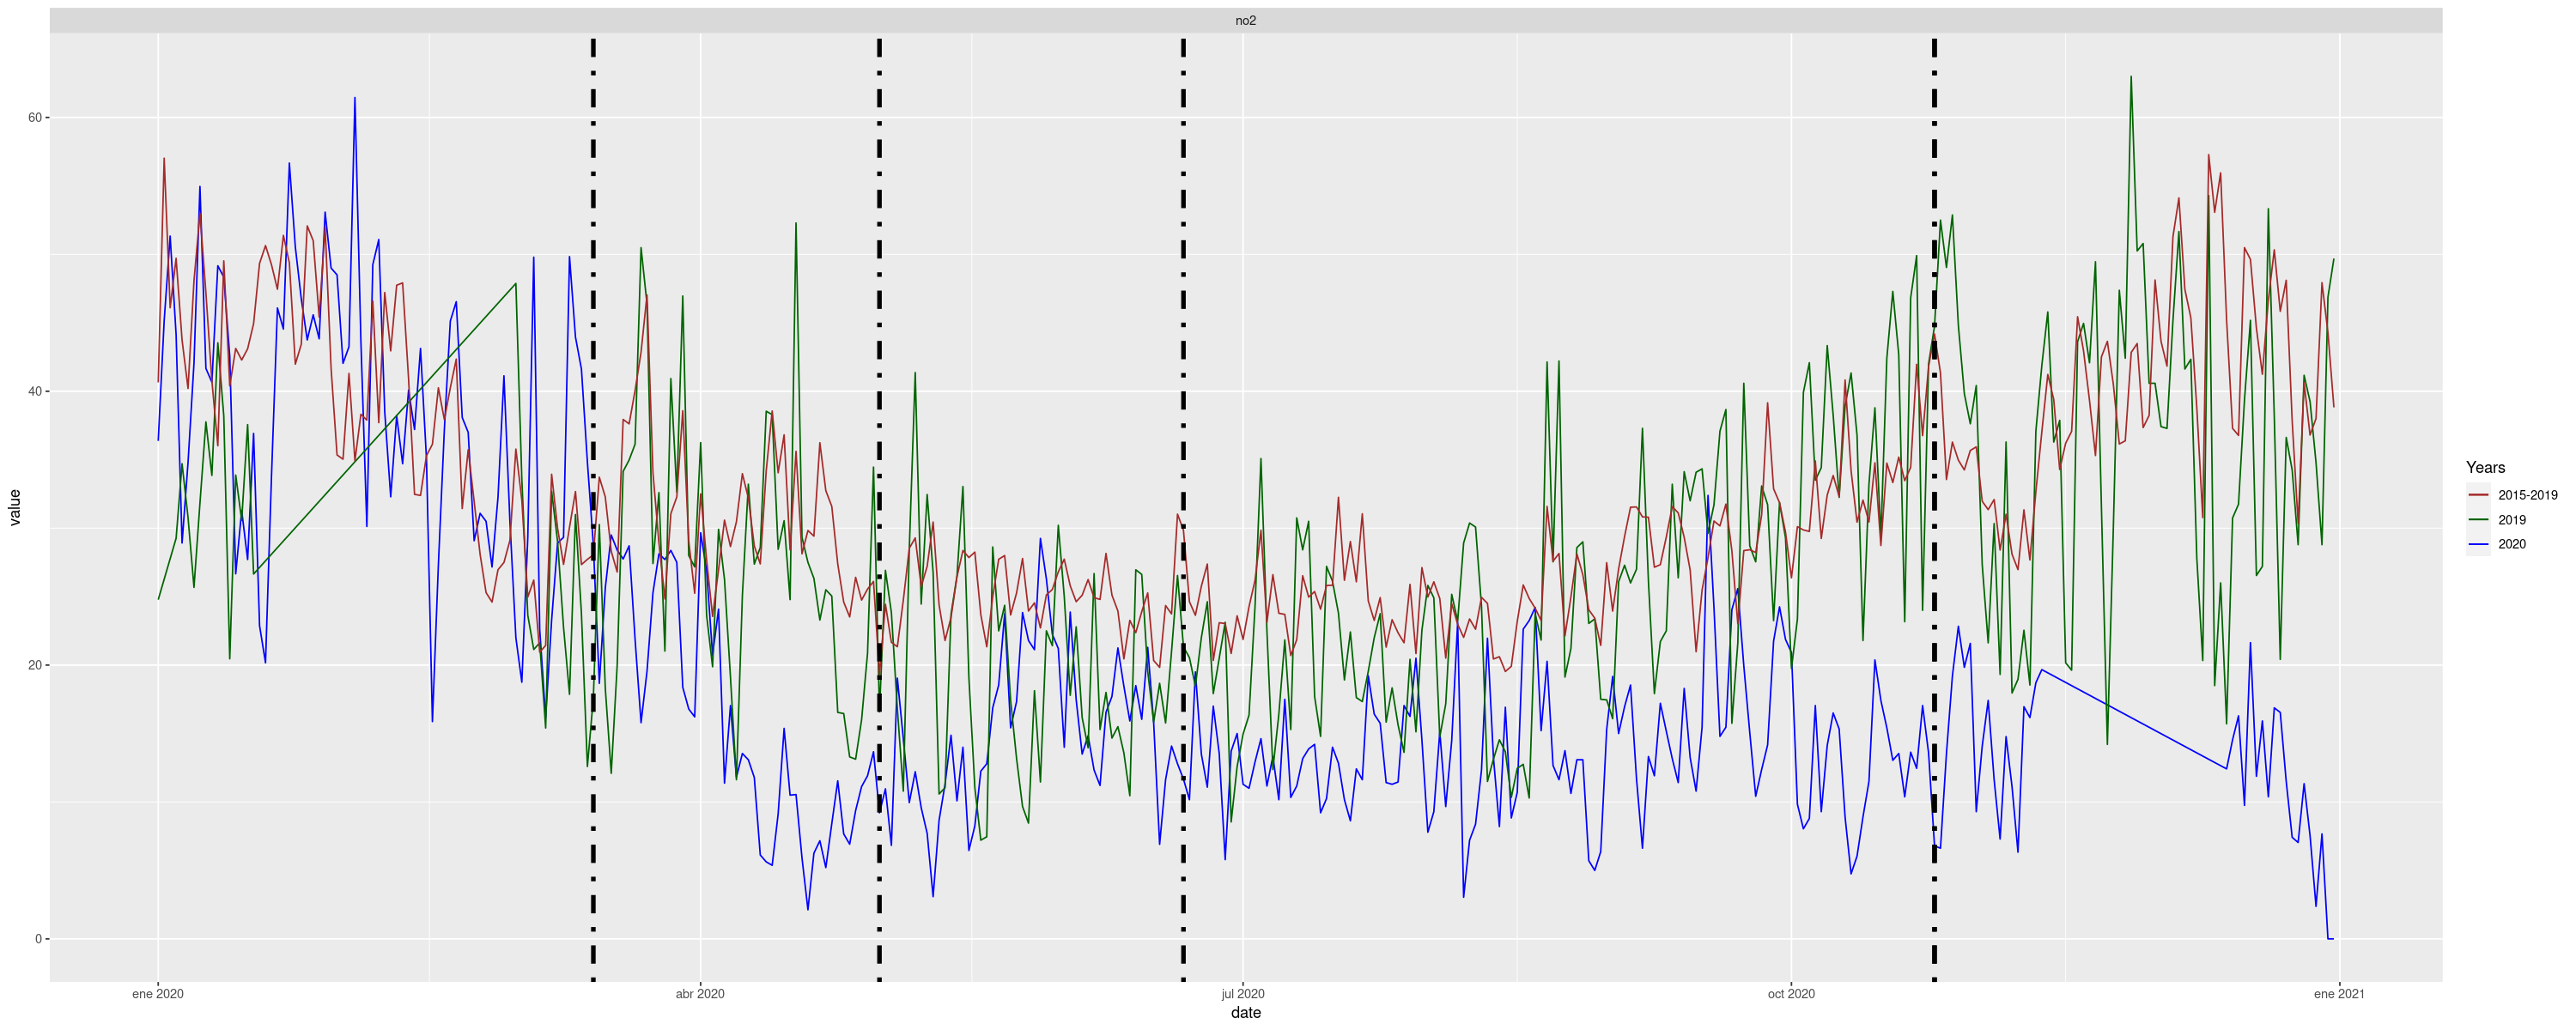

In [15]:
ggplot(data=data.frame(), aes(x=date, y=value)
       
      ) + geom_line(data=data.20, aes(color="2020")
      ) + geom_line(data=data.19, aes(color="2019")
      ) + geom_line(data=data.15.19, aes(color="2015-2019")
                    
                    
      ) + geom_vline(xintercept = as.numeric(start.lckdwn), linetype=4, 
                     color = "black", size=1.5
      #) + geom_text(label="hola a todos", hjust=0, vjust=0
      #) + geom_vline(xintercept = as.numeric(end.lckdwn), linetype=4, 
      #               color = "black", size=1.5
      ) + geom_vline(xintercept = as.numeric(start.pos.lckdwn), linetype=4, 
                     color = "black", size=1.5
      ) + geom_vline(xintercept = as.numeric(end.pos.lckdwn), linetype=4, 
                     color = "black", size=1.5
      ) + geom_vline(xintercept = as.numeric(start.2.lckdwn), linetype=4, 
                     color = "black", size=1.5
      ) + geom_vline(xintercept = as.numeric(start.2.lckdwn), linetype=4, 
                     color = "black", size=1.5
      ) + scale_color_manual(name = "Years", values = c("2020" = "blue", 
                                                        "2019" = "darkgreen", 
                                                        "2015-2019" = "brown")
      ) + facet_wrap(~variable, ncol=1)

#+geom_line(data=data.santander.cl, color="red")